# New resolution tests informed by literature review

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Estimating the resolution necessary for accurate results

### Mean grid spacing: Grötzbach (1983) approximate conditions
Two different approximations give (for $\mathrm{Pr}=1$)
$$
    (\Delta x \Delta z)^{1/2} \lesssim 4.758\,\mathrm{Ra}^{-0.3205}
$$
and
$$
    (\Delta x \Delta z)^{1/2} \lesssim 5.23\,\mathrm{Ra}^{-0.3205}.
$$
At $\mathrm{Ra} = 10^9$ we get

In [2]:
5 * (1e9)**(-0.3205)

0.006523339843199475

whereas the mean grid spacing for a resolution of 1024 x 192 is

In [50]:
((8/1024)*(1/192))**(1/2)

0.00637887953849786

which, surprisingly, indicates that the current resolution satisfies the condition!

### Mean grid spacing: Grötzbach (1983) rigorous condition
Grötzbach argues that we have to resolve everything down the Kolmogorov length:
$$
    (\Delta x \Delta z)^{1/2} \leq \pi \eta
$$
Where the Kolmogorov length $\eta$ is defined by (Scheel, Emran and Schumacher 2013):
$$
    \eta \equiv \left( \frac{\mathrm{Pr}}{\mathrm{Ra}} \right)^{3/8}
        \langle \epsilon \rangle^{-1/4}
$$
and $\langle \epsilon \rangle$ is the spatial and temporal mean of the kinetic energy dissipation rate
$$
    \epsilon(\vec{x},t) \equiv \frac{1}{2}
        \left( \frac{\mathrm{Pr}}{\mathrm{Ra}} \right)^{1/2}
        \sum_{ij} \left(
            \frac{\partial u_i}{x_j} + \frac{\partial u_j}{x_i}
        \right)^2.
$$

I compute this using the last 50 time units of data from the highest-resolution run so far (1024 x 192):

In [41]:
data = xr.open_mfdataset(
    '../data/restest_highRa_v2/1024_192/*.nc',
    chunks={'t': 100, 'x': -1, 'z': -1}
)
data = data.isel(t=(data.t >= 50))

In [46]:
# Compute the Jacobian du_i/dx_j
jacobian = [[None, None], [None, None]]
coords = ['x', 'z']
components = [data.u, data.w]
for i in range(2):
    for j in range(2):
        jacobian[i][j] = components[i].differentiate(coords[j])

# Compute the sum
dissipation = 0
for i in range(2):
    for j in range(2):
        dissipation += (jacobian[i][j] + jacobian[j][i])**2

# average over space and time
dissipation = dissipation.integrate(['x', 'z', 't'])
for dim in ['x', 'z', 't']:
    dissipation /= data[dim].max() - data[dim].min()

# Multiply by 1/2 (Pr/Ra)^(1/2)
prandtl = 1
rayleigh = 1e9
dissipation *= 0.5*(prandtl/rayleigh)**0.5

# Calculate the Kolmogorov length
kolmogorov_length = (prandtl/rayleigh)**(3/8) * dissipation**(-1/4)
kolmogorov_length = kolmogorov_length.compute().item()

So according to Grötzbach the mean grid spacing should be

In [48]:
np.pi*kolmogorov_length

0.007259905950292136


which is only slightly larger than the approximate value of 0.0065 that we obtained before. Recall that our average grid spacing is

In [53]:
((8/1024)*(1/192))**(1/2)

0.00637887953849786

which, again, satisfies Grötzbach's condition!

### Number of points in thermal boundary layer
There must be sufficiently many vertical levels within the thermal boundary layer, which has thickness (Chillà and Schumacher 2012)
$$
    \delta_T = \frac{1}{2\,\mathrm{Nu}(z=0)} = -\frac{1}{2} \left( \left. \frac{\partial \langle \theta \rangle _{A,t}}{\partial z} \right|_{z=0} \right)^{-1}
$$
where $\langle \cdot \rangle _{A,t}$ denotes denotes horizontal and temporal averaging. I find $\delta_T$ to be

In [103]:
profile = data.theta.mean(['x', 't']).compute()
lapse_rate = -profile.differentiate('z')
bl_thickness = 0.5/lapse_rate.isel(z=0)
print(bl_thickness.item())

0.010832330805456187


and visualise this value on a plot of the temperature profile:

[Text(0.5, 0, '$\\langle \\theta \\rangle _{A,t}$'), Text(0, 0.5, '$z$')]

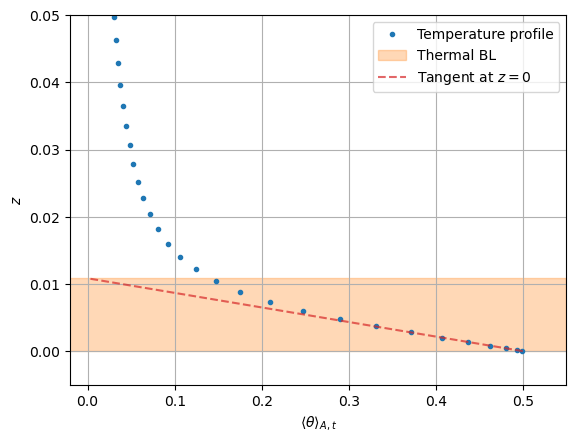

In [98]:
z = np.linspace(0, bl_thickness, 10)
fig, ax = plt.subplots()
ax.plot(profile, profile.z, '.', label='Temperature profile')
ax.fill_between(
    ax.get_xlim(), 0, bl_thickness, color='tab:orange', alpha=0.3,
    label='Thermal BL'
)
ax.plot(
    0.5 - lapse_rate.isel(z=0).item()*z, z, '--', color='tab:red', alpha=0.7,
    label='Tangent at $z=0$'
)
ax.set_xlim(-0.02, 0.55)
ax.set_ylim(-0.005, 0.05)
ax.grid()
ax.legend()
ax.set(xlabel=r'$\langle \theta \rangle _{A,t}$', ylabel='$z$')

Indeed, there are

In [101]:
(data.z <= bl_thickness).sum().item()

13

vertical levels in the thermal boundary layer. Grötzbach (1983) recommended only 3, and Shishkina et al. (2010) recommended 9 for $\mathrm{Ra} = 2 \times 10^9$ based on a theoretical argument.

### Conclusion
According to the basic conditions available in the literature, a 1024 x 192 grid should be producing a reasonably accurate solution.

**Question**: To what extent are the conditions in the literature applicable to spectral methods?

## Resolution dependence tests

### Mean Nusselt number
Local, instantaneous value (Scheel, Emran, and Schumacher 2013):
$$
\mathrm{Nu}(z,t) \equiv (\mathrm{Ra}\,\mathrm{Pr})^{1/2} \langle w \theta \rangle _x
    - \frac{\partial \langle \theta \rangle _x}{\partial z}.
$$
Conservation of energy requires that the time average is spatially uniform:
$$
\langle \mathrm{Nu}(z,t) \rangle _t = \langle \mathrm{Nu}(z,t) \rangle _{z,t}
    = 1 + (\mathrm{Ra}\,\mathrm{Pr})^{1/2} \langle w \theta \rangle _{x,z,t} \qquad \text{for all } z.
$$
There is no need to coarse-grain the data from the high-resolution runs because we are taking a global average anyway.

In [34]:
data = {}
nx_list = [256, 384, 512, 768, 1024]
nz_list = [128, 192]
for nx in nx_list:
    for nz in nz_list:
        if (nx, nz) == (1024, 128):
            continue
        name = f'{nx}_{nz}/*.nc'
        ds = xr.open_mfdataset(
            f'../data/restest_highRa_v2/{name}',
            chunks={'t': 100, 'x': -1, 'z': -1})
        ds = ds.drop_duplicates('t')
        data[(nx, nz)] = ds.isel(t=(ds.t.max() - ds.t <= 50))

ds = xr.open_mfdataset(
    '../data/highRa_tests/nonlinear_hyper_test/*.nc',
    chunks={'t': 100, 'x': -1, 'z': -1})
ds = ds.drop_duplicates('t')
data[(1024, 128)] = ds.isel(t=(ds.t.max() - ds.t <= 50))

In [35]:
rayleigh = 1e9
prandtl = 1

def mean_nusselt_number(data):
    convection = np.sqrt(rayleigh*prandtl)*(data.w*data.theta).mean(['x', 't'])
    return 1 + convection.integrate('z')/(data.z.max() - data.z.min())

In [36]:
mean_nusselt = xr.DataArray(
    coords={'nx': nx_list, 'nz': nz_list},
    dims=['nx', 'nz'],
)
for nx, nz in data.keys():
    nu = mean_nusselt_number(data[(nx, nz)])
    mean_nusselt.loc[{'nx': nx, 'nz': nz}] = nu

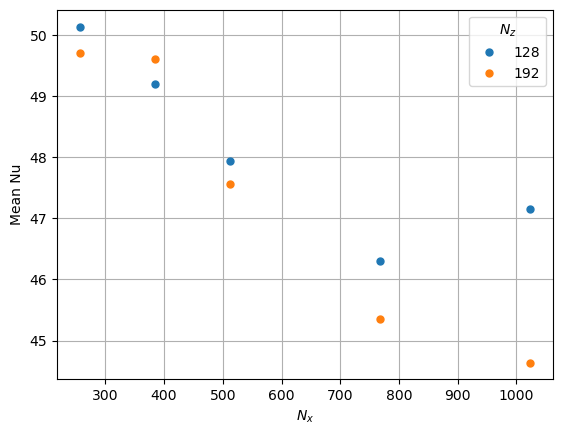

In [37]:
fig, ax = plt.subplots()
ax.plot(
    mean_nusselt.nx, mean_nusselt.data, '.',
    markersize=10, label=mean_nusselt.nz.data)
ax.grid()
ax.set(
    xlabel='$N_x$',
    ylabel='Mean Nu',
)
ax.legend(title='$N_z$')

Finally, a monotonic resolution dependence! The mean Nu clearly increases when the flow is horizontally under-resolved. This is consistent with the literature, e.g. Stevens, Verzicco, and Lohse (2010).

### Mean kinetic energy dissipation rate

In [38]:
def mean_kinetic_dissipation(data):
    # Compute the Jacobian du_i/dx_j
    jacobian = [[None, None], [None, None]]
    coords = ['x', 'z']
    components = [data.u, data.w]
    for i in range(2):
        for j in range(2):
            jacobian[i][j] = components[i].differentiate(coords[j])

    # Compute the sum
    dissipation = 0
    for i in range(2):
        for j in range(2):
            dissipation += (jacobian[i][j] + jacobian[j][i])**2

    # average over space and time
    dissipation = dissipation.mean(['x', 't'])
    dissipation = dissipation.integrate('z')/(data.z.max() - data.z.min())
    dissipation *= 0.5*(prandtl/rayleigh)**0.5
    return dissipation

In [39]:
epsilon = xr.DataArray(
    coords={'nx': nx_list, 'nz': nz_list},
    dims=['nx', 'nz'],
)
for nx, nz in data.keys():
    eps = mean_kinetic_dissipation(data[(nx, nz)])
    epsilon.loc[{'nx': nx, 'nz': nz}] = eps

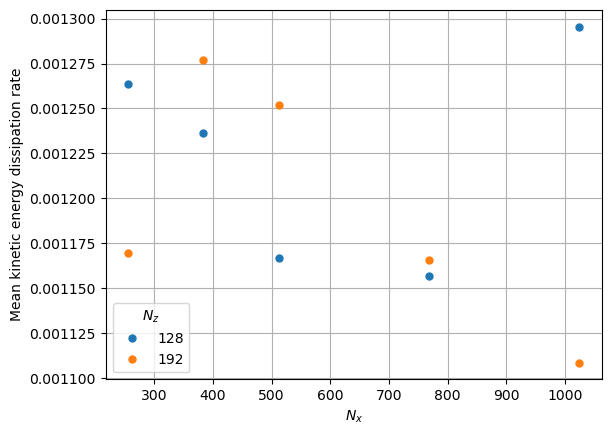

In [40]:
fig, ax = plt.subplots()
ax.plot(
    epsilon.nx, epsilon.data, '.',
    markersize=10, label=epsilon.nz.data)
ax.grid()
ax.set(
    xlabel='$N_x$',
    ylabel='Mean kinetic energy dissipation rate',
)
ax.legend(title='$N_z$')

### Mean thermal dissipation rate

In [41]:
def mean_thermal_dissipation(data):
    dissipation = (
        data.theta.differentiate('x')**2
        + data.theta.differentiate('z')**2
    )

    # average over space and time
    dissipation = dissipation.mean(['x', 't'])
    dissipation = dissipation.integrate('z')/(data.z.max() - data.z.min())
    dissipation *= (rayleigh*prandtl)**(-0.5)
    return dissipation

In [42]:
epsilon_T = xr.DataArray(
    coords={'nx': nx_list, 'nz': nz_list},
    dims=['nx', 'nz'],
)
for nx, nz in data.keys():
    eps = mean_thermal_dissipation(data[(nx, nz)])
    epsilon_T.loc[{'nx': nx, 'nz': nz}] = eps

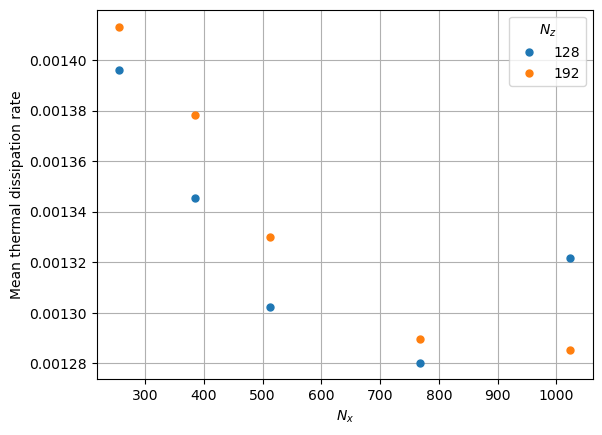

In [43]:
fig, ax = plt.subplots()
ax.plot(
    epsilon_T.nx, epsilon_T.data, '.',
    markersize=10, label=epsilon_T.nz.data)
ax.grid()
ax.set(
    xlabel='$N_x$',
    ylabel='Mean thermal dissipation rate',
)
ax.legend(title='$N_z$')

### What's going on with 1024 x 128?

In [120]:
data = {}
nx_list = [256, 384, 512, 768, 1024]
nz_list = [128, 192]
for nx in nx_list:
    for nz in nz_list:
        if (nx, nz) == (1024, 128):
            continue
        name = f'{nx}_{nz}/*.nc'
        ds = xr.open_mfdataset(
            f'../data/restest_highRa_v2/{name}',
            chunks={'t': 100, 'x': -1, 'z': -1})
        data[(nx, nz)] = ds.drop_duplicates('t')

ds = xr.open_mfdataset(
    '../data/highRa_tests/nonlinear_hyper_test/*.nc',
    chunks={'t': 100, 'x': -1, 'z': -1})
data[(1024, 128)] = ds.drop_duplicates('t')

In [121]:
def nusselt_number(data):
    convection = np.sqrt(rayleigh*prandtl)*(data.w*data.theta).mean(['x'])
    return 1 + convection.integrate('z')/(data.z.max() - data.z.min())

In [122]:
nusselt = {}
for res in data:
    nusselt[res] = nusselt_number(data[res]).chunk({'t': -1}).compute()

(10.0, 90.0)

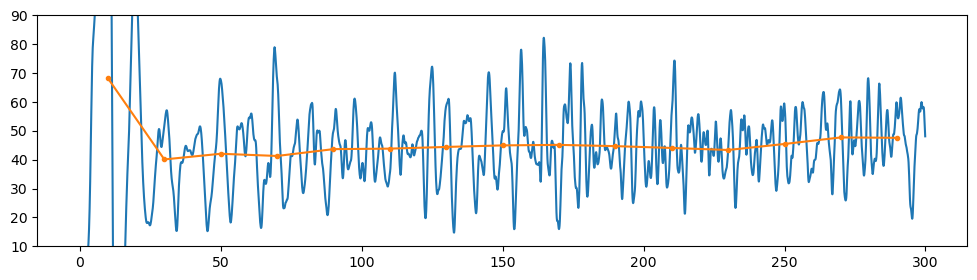

In [205]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(nusselt[1024, 128].t, nusselt[1024, 128])
bin_edges = np.linspace(0, 300, 16)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
mean = nusselt[1024, 128].groupby_bins('t', bin_edges).mean()
ax.plot(bin_centers, mean, '.-')
ax.set_ylim(10, 90)

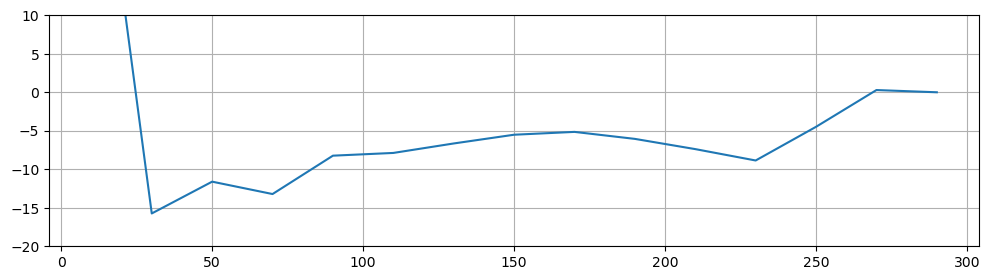

In [168]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(bin_centers, (mean/mean[-1] - 1)*1e2)
ax.set_ylim(-20, 10)
ax.grid()

In [82]:
def _running_mean(data):
    mean = np.zeros_like(data)
    mean[0] = data[0]
    for i in range(1, data.shape[-1]):
        mean[i] = mean[i-1]*i/(i + 1) + data[i]/(i + 1)

    return mean

def running_mean(data, dim):
    return xr.apply_ufunc(
        _running_mean, data,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

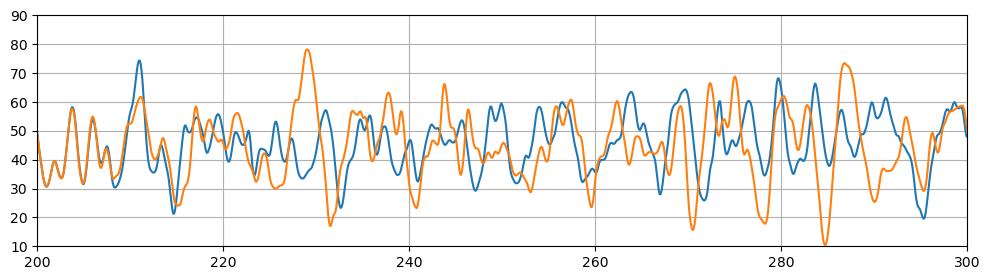

In [154]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(nusselt[1024, 128].t, nusselt[1024, 128])
ax.plot(nusselt[1024, 192].t + 200, nusselt[1024, 192])
ax.set_ylim(10, 90)
ax.set_xlim(200, 300)
ax.grid()

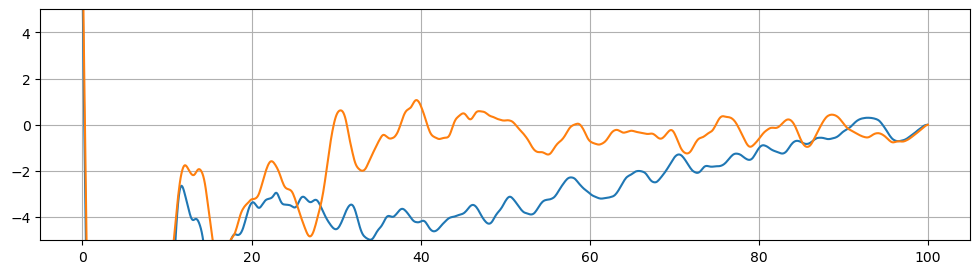

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
for res in [(1024, 128), (1024, 192)]:
    mean = running_mean(nusselt[res], 't')
    ax.plot(mean.t, (mean/mean[-1] - 1)*1e2)
ax.set_ylim(-5, 5)
ax.grid()

Conclusion: the 1024 x 128 run, which is used to initialise the other runs, has not reached a statistically steady state. This means we need to run a longer spin-up simulation and re-do the resolution tests to conclusively demonstrate a resolution effect.